<a href="https://colab.research.google.com/github/satani99/course22p2/blob/master/augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
!git clone https://github.com/fastai/course22p2.git
%cd course22p2

Cloning into 'course22p2'...
remote: Enumerating objects: 1176, done.
remote: Counting objects: 100% (1176/1176), done.
remote: Compressing objects: 100% (480/480), done.
remote: Total 1176 (delta 712), reused 1117 (delta 694), pack-reused 0
Receiving objects: 100% (1176/1176), 99.81 MiB | 31.85 MiB/s, done.
Resolving deltas: 100% (712/712), done.
/content/course22p2/course22p2/course22p2


In [90]:
!pip install datasets
!pip install torcheval

In [91]:
import torch,random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [92]:
import pickle,gzip,math,os,time,shutil
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,optim
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [93]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [94]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [95]:
set_seed(42)
lr, epochs = 6e-2, 5

In [96]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
  layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
  layers += [ResBlock(nfs[i], nfs[i+1], act=act, stride=2) for i in range(len(nfs)-1)]
  layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
  return nn.Sequential(*layers)

In [97]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.811,0.748,0,train
0.869,0.441,0,eval
0.893,0.399,1,train
0.885,0.362,1,eval
0.919,0.276,2,train
0.911,0.302,2,eval
0.940,0.202,3,train
0.924,0.238,3,eval
0.963,0.138,4,train
0.927,0.239,4,eval


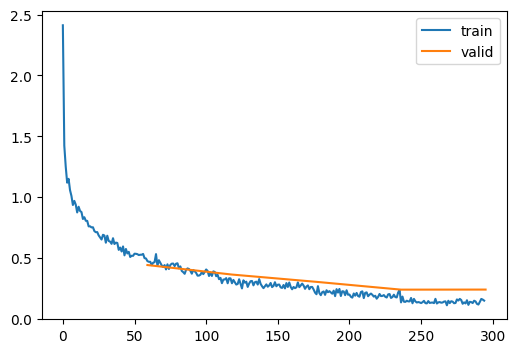

In [98]:
learn.fit(epochs)

In [99]:
class GlobalAvgPool(nn.Module):
  def forward(self, x): return x.mean((-2,-1))

In [100]:
def get_model2(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
  layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
  layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
  layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
  layers += [nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)]
  return nn.Sequential(*layers)

In [101]:
def _flops(x, h, w):
  if x.dim()<3: return x.numel()
  if x.dim()==4: return x.numel()*h*w

@fc.patch()
def summary(self:Learner):
  res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
  totp, totf = 0,0
  def _f(hook, mod, inp, outp):
    nonlocal res, totp, totf
    nparams = sum(o.numel() for o in mod.parameters())
    totp += nparams
    *_,h,w = outp.shape
    flops = sum(_flops(o,h,w) for o in mod.parameters())/1e6
    totf += flops
    res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparams}|{flops:.1f}|\n'
  with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
  print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
  if fc.IN_NOTEBOOK:
    from IPython.display import Markdown
    return Markdown(res)
  else: print(res)

In [102]:
TrainLearner(get_model2(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 4907588; MFLOPS: 33.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3673600|14.7|
|GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5120|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.822,0.715,0,train
0.863,0.516,0,eval
0.898,0.384,1,train
0.882,0.415,1,eval
0.920,0.270,2,train
0.904,0.309,2,eval
0.941,0.199,3,train
0.926,0.240,3,eval
0.961,0.142,4,train
0.930,0.224,4,eval


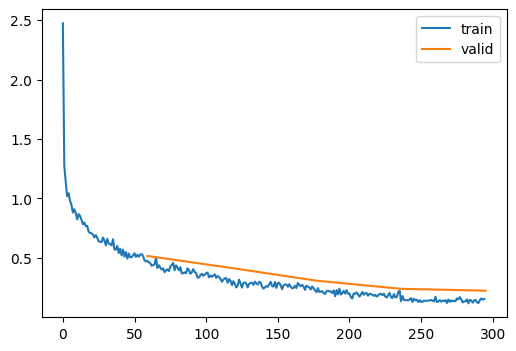

In [103]:
set_seed(42)
model = get_model2(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [104]:
def get_model3(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
  layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
  layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
  layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
  return nn.Sequential(*layers)

In [105]:
TrainLearner(get_model3(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1231428; MFLOPS: 18.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


In [106]:
[o.shape for o in get_model3()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 16, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 1, 1, 1]),
 torch.Size([16])]

accuracy,loss,epoch,train
0.810,0.758,0,train
0.867,0.459,0,eval
0.894,0.401,1,train
0.894,0.369,1,eval
0.920,0.276,2,train
0.896,0.328,2,eval
0.939,0.208,3,train
0.922,0.244,3,eval
0.961,0.152,4,train
0.930,0.229,4,eval


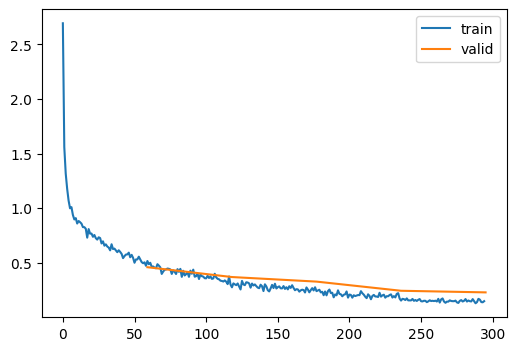

In [107]:
set_seed(42)
model = get_model3(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [108]:
def get_model4(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
  layers = [conv(1, 16, ks=5, stride=1, act=act, norm=norm)]
  layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
  layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
  return nn.Sequential(*layers)

In [109]:
[o.shape for o in get_model4()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16])]

In [110]:
TrainLearner(get_model4(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1224948; MFLOPS: 13.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 16, 28, 28)|448|0.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.804,0.782,0,train
0.871,0.479,0,eval
0.898,0.391,1,train
0.894,0.352,1,eval
0.919,0.275,2,train
0.898,0.329,2,eval
0.941,0.200,3,train
0.925,0.243,3,eval
0.962,0.147,4,train
0.927,0.237,4,eval


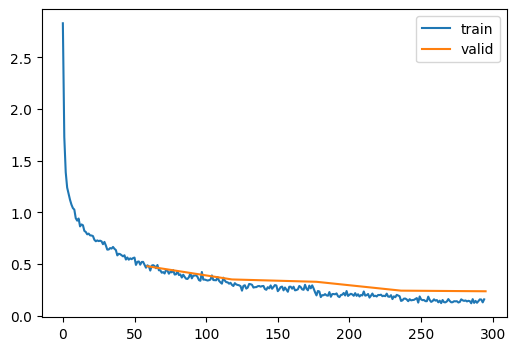

In [111]:
set_seed(42)
model = get_model4(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [112]:
from torchvision import transforms

In [113]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop): return tfm_x(b[0]), tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                     transforms.RandomHorizontalFlip())

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[SingleBatchCB(), augcb])

In [114]:
learn.fit(1)


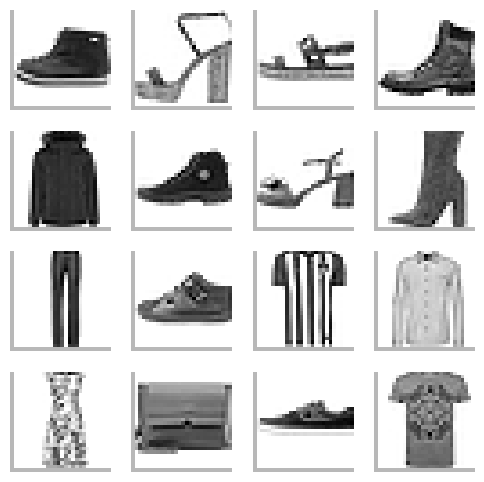

In [115]:
xb, yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [116]:
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Learner, max_n=9, cbs=None, **kwargs):
  self.fit(1, cbs=[SingleBatchCB()]+fc.L(cbs))
  show_images(self.batch[0][:max_n], **kwargs)

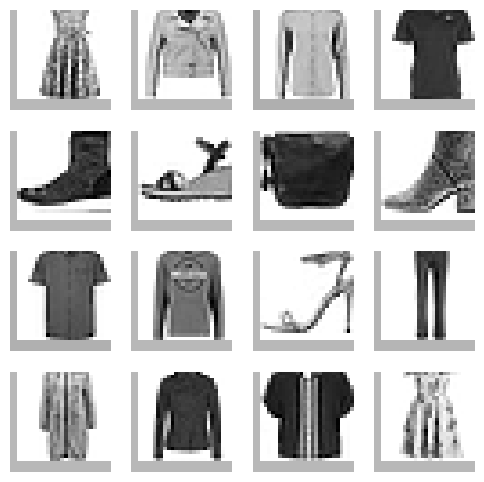

In [117]:
learn.show_image_batch(max_n=16, imsize=(1.5))

In [118]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

accuracy,loss,epoch,train
0.733,0.975,0,train
0.816,0.674,0,eval
0.841,0.644,1,train
0.844,0.535,1,eval
0.864,0.513,2,train
0.843,0.456,2,eval
0.876,0.429,3,train
0.860,0.423,3,eval
0.885,0.364,4,train
0.862,0.429,4,eval


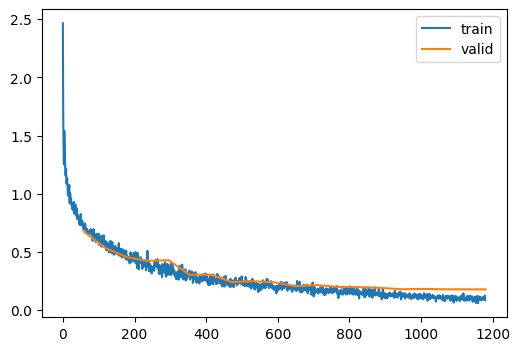

In [119]:
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [120]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)
torch.save(learn.model, mdl_path/'data_aug.pkl')

In [121]:
class CapturePreds(Callback):
  def before_fit(self, learn): self.all_inps, self.all_preds, self.all_targs = [], [], []
  def after_batch(self, learn):
    self.all_inps.append(to_cpu(learn.batch[0]))
    self.all_preds.append(to_cpu(learn.preds))
    self.all_targs.append(to_cpu(learn.batch[1]))
  def after_fit(self, learn):
    self.all_preds, self.all_targs, self.all_inps = map(torch.cat, [self.all_preds, self.all_targs, self.all_inps])

In [122]:
@fc.patch
def capture_preds(self:Learner, cbs=None, inps=False):
  cp = CapturePreds()
  self.fit(1, train=False, cbs=[cp]+fc.L(cbs))
  res = cp.all_preds, cp.all_targs
  if inps: res = res + (cp.all_inps,)
  return res

accuracy,loss,epoch,train
0.942,0.178,0,eval


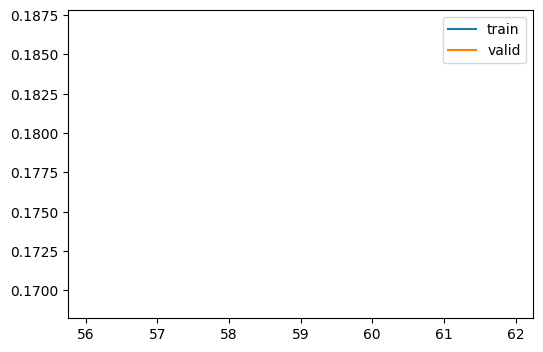

In [123]:
ap1, at = learn.capture_preds()

accuracy,loss,epoch,train
0.939,0.181,0,eval


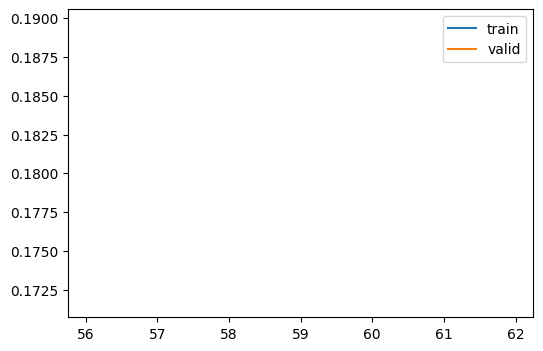

In [124]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

In [125]:
ap1.shape, ap2.shape, at.shape

(torch.Size([10000, 10]), torch.Size([10000, 10]), torch.Size([10000]))

In [126]:
ap = torch.stack([ap1, ap2]).mean(0).argmax(1)

In [127]:
round((ap==at).float().mean().item(), 3)

0.942

In [128]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]

In [129]:
xm, xs = xbt.mean(), xbt.std()

In [130]:
xbt.min(), xbt.max()

(tensor(-0.80), tensor(2.06))

In [131]:
pct = 0.2

In [132]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx = int(random.random()*(1-pct)*xbt.shape[-2])
sty = int(random.random()*(1-pct)*xbt.shape[-1])
stx, sty, szx, szy

(14, 0, 5, 5)

In [133]:
init.normal_(xbt[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs);

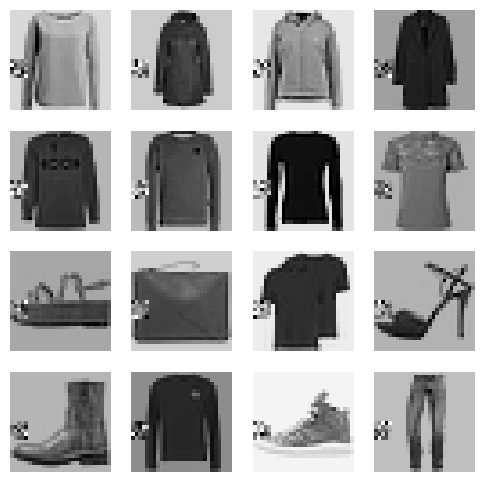

In [134]:
show_images(xbt, imsize=1.5)

In [135]:
xbt.min(), xbt.max()

(tensor(-3.36), tensor(2.56))

In [136]:
def _rand_erase1(x, pct, xm, xs, mn, mx):
  szx = int(pct*x.shape[-2])
  szy = int(pct*x.shape[-1])
  stx = int(random.random()*(1-pct)*x.shape[-2])
  sty = int(random.random()*(1-pct)*x.shape[-1])
  init.normal_(x[:, :, stx:stx+szx, sty:sty+szy], mean=xm, std=xs)
  x.clamp_(mn, mx)

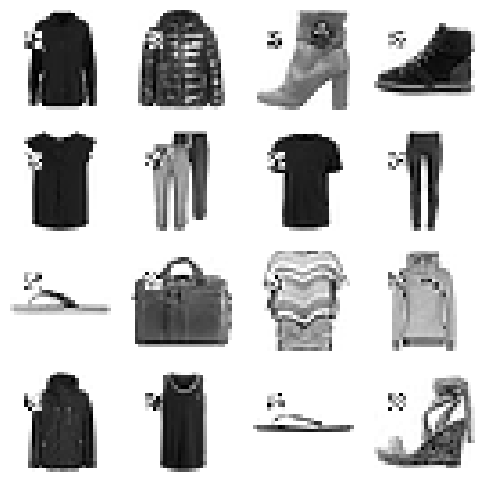

In [137]:
xb, _ = next(iter(dls.train))
xbt = xb[:16]
_rand_erase1(xbt, 0.2, xbt.mean(), xbt.std(), xbt.min(),xbt.max())
show_images(xbt, imsize=1.5)

In [138]:
xbt.mean(), xbt.std(), xbt.min(), xbt.max()

(tensor(0.09), tensor(1.04), tensor(-0.80), tensor(2.06))

In [139]:
def rand_erase(x, pct=0.2, max_num=4):
  xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
  num = random.randint(0, max_num)
  for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
  return x

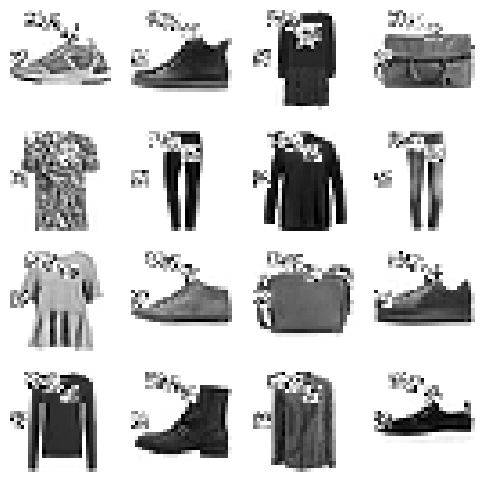

In [142]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
rand_erase(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [143]:
class RandErase(nn.Module):
  def __init__(self, pct=0.2, max_num=4):
    super().__init__()
    self.pct, self.max_num = pct, max_num
  def forward(self, x): return rand_erase(x, self.pct, self.max_num)

In [144]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

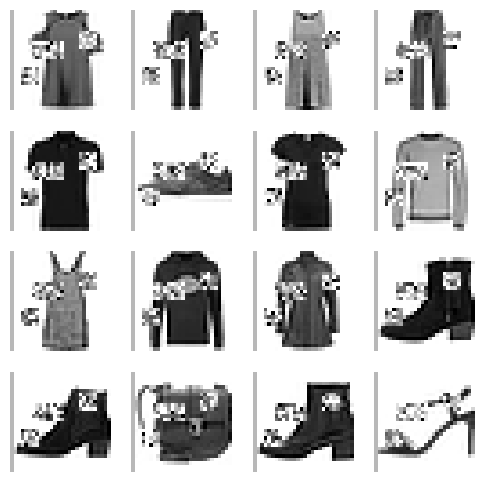

In [145]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(),augcb])
learn.fit(1)
xb, yb = learn.batch
show_images(xb[:16], imsize=1.5)

accuracy,loss,epoch,train
0.724,0.982,0,train
0.806,0.657,0,eval
0.825,0.670,1,train
0.783,0.674,1,eval
0.841,0.587,2,train
0.842,0.496,2,eval
0.857,0.508,3,train
0.869,0.410,3,eval
0.861,0.457,4,train
0.877,0.374,4,eval


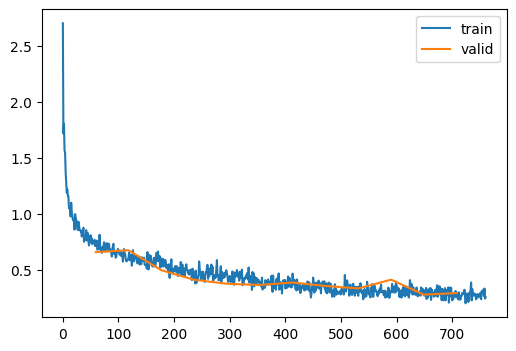

In [ ]:
epochs = 50
lr = 2e-2
tmax =epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]